Detected spike coordinates: [(267, 255), (245, 257)]
Number of spikes detected: 2


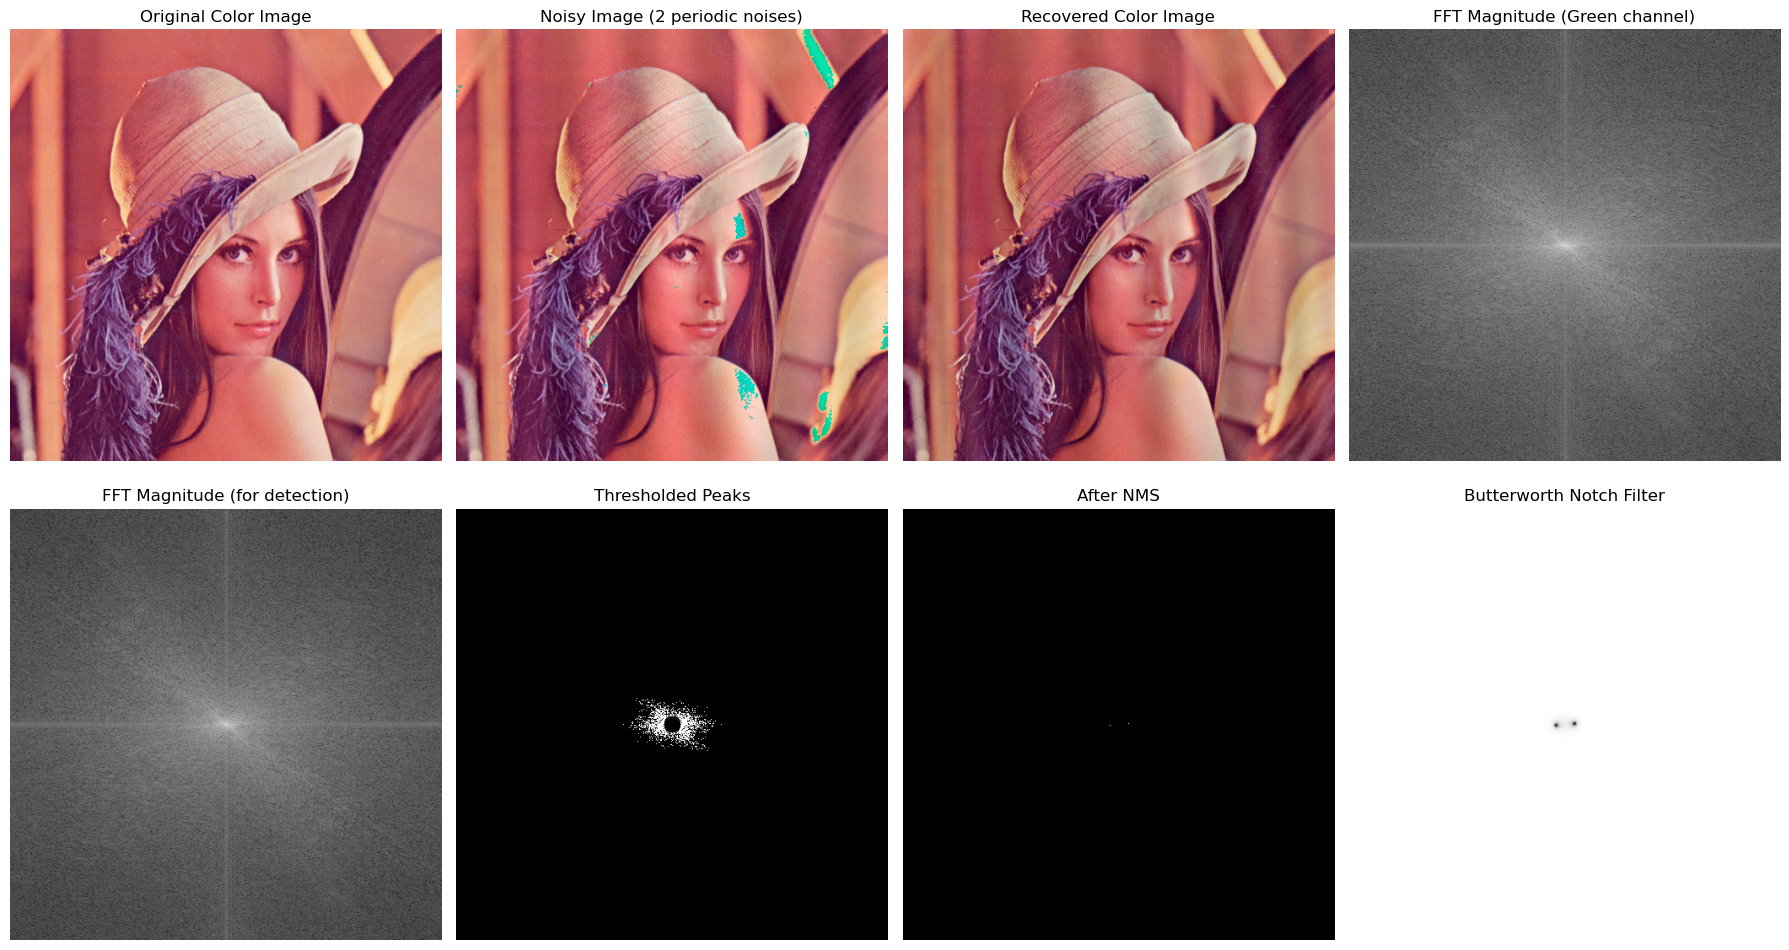


Processing complete!
Saved: noisy_color_image.png, recovered_color_image.png, color_periodic_noise_removal_result.png


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.fft import fft2, ifft2, fftshift, ifftshift

def add_periodic_noise_color(image, noise_params):
    """
    Add periodic noise to a color image by manipulating frequency domain.

    Parameters:
    - image: input color image (H x W x 3)
    - noise_params: list of tuples [(u_offset, v_offset, amplitude_pct), ...]

    Returns:
    - noisy_image: color image with periodic noise
    - F_channels: list of FFT for each channel
    """
    rows, cols = image.shape[:2]
    noisy_channels = []
    F_channels = []

    for ch in range(3):  # Process each BGR channel
        channel = image[:, :, ch]
        F = fftshift(fft2(channel))
        max_val = np.max(np.abs(F))

        # Add noise spikes
        for u_offset, v_offset, amp_pct in noise_params:
            amp = amp_pct * max_val
            F[rows//2 + v_offset, cols//2 + u_offset] += amp
            F[rows//2 - v_offset, cols//2 - u_offset] += amp

        F_channels.append(F)
        noisy_channel = np.abs(ifft2(ifftshift(F)))
        noisy_channels.append(noisy_channel)

    noisy_image = np.stack(noisy_channels, axis=2)
    return noisy_image, F_channels


def detect_periodic_noise_spikes(F, rows, cols, dc_mask_radius=10, threshold_factor=3, nms_kernel_size=21):
    """
    Detect periodic noise spike locations in frequency domain.

    Parameters:
    - F: shifted FFT of image
    - rows, cols: image dimensions
    - dc_mask_radius: radius to mask DC component
    - threshold_factor: number of std deviations above mean for thresholding
    - nms_kernel_size: kernel size for non-maximum suppression

    Returns:
    - coords: list of (x, y) coordinates of detected spikes
    """
    # Compute log magnitude spectrum
    magnitude_spectrum = np.log1p(np.abs(F))

    # Mask DC component
    mask = np.ones_like(magnitude_spectrum)
    cv2.circle(mask, (cols//2, rows//2), dc_mask_radius, 0, -1)
    spectrum_masked = magnitude_spectrum * mask

    # Adaptive threshold
    mean_val = np.mean(spectrum_masked)
    std_val = np.std(spectrum_masked)
    T = mean_val + threshold_factor * std_val
    binary_mask = (spectrum_masked > T).astype(np.uint8)

    # Non-Maximum Suppression
    norm = cv2.normalize(spectrum_masked, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    kernel = np.ones((nms_kernel_size, nms_kernel_size), np.uint8)
    local_max = cv2.dilate(norm, kernel)
    nms = np.zeros_like(norm, np.uint8)
    nms[(norm == local_max) & (binary_mask == 1)] = 255

    # Extract coordinates
    coords = cv2.findNonZero(nms)
    if coords is not None:
        coords = [tuple(pt[0]) for pt in coords]
    else:
        coords = []

    return coords, magnitude_spectrum, binary_mask, nms


def butterworth_notch_reject(shape, D0=10, n=2, notch_centers=[]):
    """
    Create Butterworth notch reject filter.

    Parameters:
    - shape: (rows, cols) of image
    - D0: notch radius
    - n: filter order
    - notch_centers: list of (x, y) coordinates to reject

    Returns:
    - H: Butterworth notch filter
    """
    rows, cols = shape
    H = np.ones((rows, cols), dtype=np.float32)
    u = np.arange(rows) - rows/2
    v = np.arange(cols) - cols/2
    V, U = np.meshgrid(v, u)

    for (x, y) in notch_centers:
        u_k = y - cols/2
        v_k = x - rows/2
        Dk = np.sqrt((U - u_k)**2 + (V - v_k)**2)
        Dk_neg = np.sqrt((U + u_k)**2 + (V + v_k)**2)
        H *= 1 / (1 + ((D0**2) / (Dk * Dk_neg + 1e-6))**n)

    return H


def remove_periodic_noise_color(noisy_image, D0=10, n=2, dc_mask_radius=10, 
                                 threshold_factor=3, nms_kernel_size=21, 
                                 detection_channel='average'):
    """
    Remove periodic noise from color image using Butterworth notch reject filter.

    Parameters:
    - noisy_image: input noisy color image
    - D0: notch radius for Butterworth filter
    - n: Butterworth filter order
    - dc_mask_radius: radius to mask DC component during spike detection
    - threshold_factor: threshold parameter for spike detection
    - nms_kernel_size: kernel size for non-maximum suppression
    - detection_channel: 'average', 'gray', or channel index (0,1,2) for spike detection

    Returns:
    - recovered_image: denoised color image
    - coords: detected spike coordinates
    - H: Butterworth notch filter used
    """
    rows, cols = noisy_image.shape[:2]

    # Determine which channel/combination to use for spike detection
    if detection_channel == 'average':
        # Average all channels for spike detection
        detection_img = np.mean(noisy_image, axis=2)
    elif detection_channel == 'gray':
        # Convert to grayscale for spike detection
        detection_img = cv2.cvtColor(noisy_image.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    else:
        # Use specific channel
        detection_img = noisy_image[:, :, detection_channel]

    # Detect spikes from the detection channel
    F_detect = fftshift(fft2(detection_img))
    coords, magnitude_spectrum, binary_mask, nms = detect_periodic_noise_spikes(
        F_detect, rows, cols, dc_mask_radius, threshold_factor, nms_kernel_size
    )

    if len(coords) == 0:
        print("Warning: No spikes detected!")
        return noisy_image, coords, np.ones((rows, cols))

    # Create Butterworth notch filter
    H = butterworth_notch_reject((rows, cols), D0, n, coords)

    # Apply filter to each channel
    recovered_channels = []
    for ch in range(3):
        channel = noisy_image[:, :, ch]
        F = fftshift(fft2(channel))
        F_filtered = F * H
        recovered_channel = np.abs(ifft2(ifftshift(F_filtered)))
        recovered_channels.append(recovered_channel)

    recovered_image = np.stack(recovered_channels, axis=2)

    return recovered_image, coords, H, magnitude_spectrum, binary_mask, nms


# ============================================================================
# EXAMPLE USAGE: Complete pipeline for color image
# ============================================================================

# Step 1: Load color image
image = cv2.imread('Lena.jpg')  # Load as color (BGR)
if image is None:
    raise FileNotFoundError("Image 'Lena.jpg' not found!")

rows, cols = image.shape[:2]

# Step 2: Add multiple periodic noises
noise_params = [
    (6, 0, 0.05),    # (u_offset, v_offset, amplitude_percentage)
]

noisy_image, F_channels = add_periodic_noise_color(image, noise_params)

# Step 3: Remove periodic noise
recovered_image, coords, H, magnitude_spectrum, binary_mask, nms = remove_periodic_noise_color(
    noisy_image,
    D0=5,
    n=2,
    dc_mask_radius=10,
    threshold_factor=3,
    nms_kernel_size=21,
    detection_channel='average'  # Use average of all channels for detection
)

print(f"Detected spike coordinates: {coords}")
print(f"Number of spikes detected: {len(coords)}")

# Step 4: Visualization
fig = plt.figure(figsize=(18, 10))

# Row 1: Original, Noisy, Recovered
plt.subplot(2, 4, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Color Image')
plt.axis('off')

plt.subplot(2, 4, 2)
plt.imshow(cv2.cvtColor(noisy_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Noisy Image (2 periodic noises)')
plt.axis('off')

plt.subplot(2, 4, 3)
plt.imshow(cv2.cvtColor(recovered_image.astype(np.uint8), cv2.COLOR_BGR2RGB))
plt.title('Recovered Color Image')
plt.axis('off')

# Row 1: FFT magnitude (showing one channel)
plt.subplot(2, 4, 4)
plt.imshow(np.log1p(np.abs(F_channels[1])), cmap='gray')
plt.title('FFT Magnitude (Green channel)')
plt.axis('off')

# Row 2: Detection stages
plt.subplot(2, 4, 5)
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('FFT Magnitude (for detection)')
plt.axis('off')

plt.subplot(2, 4, 6)
plt.imshow(binary_mask*255, cmap='gray')
plt.title('Thresholded Peaks')
plt.axis('off')

plt.subplot(2, 4, 7)
plt.imshow(nms, cmap='gray')
plt.title('After NMS')
plt.axis('off')

plt.subplot(2, 4, 8)
plt.imshow(H, cmap='gray')
plt.title('Butterworth Notch Filter')
plt.axis('off')

plt.tight_layout()
plt.savefig('color_periodic_noise_removal_result.png', dpi=150, bbox_inches='tight')
plt.show()

# Save results
cv2.imwrite('noisy_color_image.png', noisy_image.astype(np.uint8))
cv2.imwrite('recovered_color_image.png', recovered_image.astype(np.uint8))

print("\nProcessing complete!")
print("Saved: noisy_color_image.png, recovered_color_image.png, color_periodic_noise_removal_result.png")